In [12]:
import requests
import time
import random
import json
import re
from difflib import SequenceMatcher
from numpy.random import choice
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

from src.graph_embeddings.data_util import MalwareGraph

plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
mg = MalwareGraph('../edge_lists/bin_dll_func.csv', 10000)

In [3]:
mg.get_vt_attributes('../VT_Scans.json')

In [4]:
kas_dict = {}
sym_dict = {}
for scan, node in zip(mg.responses, mg.scanned_nodes):
    if 'scans' in scan:
        kaspersky = scan['scans'].get('Kaspersky')
        symantec = scan['scans'].get('Symantec')
        if kaspersky:
            k_result = kaspersky['result']
        else:
            k_result = None
        kas_dict[node] = k_result
        if symantec:
            s_result = symantec['result']
        else:
            s_result = None
        sym_dict[node] = s_result
    else:
        kas_dict[node] = None
        sym_dict[node] = None

In [14]:
vt_labels = []
labeled_nodes = []
node_comparison = np.zeros((len(kas_dict), len(kas_dict)))
for i, node1 in enumerate(kas_dict):
    for j, node2 in enumerate(kas_dict):
        if kas_dict[node1] and kas_dict[node2]:
            node1_label = kas_dict[node1]
            node2_label = kas_dict[node2]
            
            overlap1 = SequenceMatcher(None, node1_label, node2_label).ratio()
        else:
            overlap1 = -1
            
        if sym_dict[node1] and sym_dict[node2]:
            node1_label = sym_dict[node1]
            node2_label = sym_dict[node2]
            
            overlap2 = SequenceMatcher(None, node1_label, node2_label).ratio()
        else:
            overlap2 = -1
        
        if overlap1 == -1 and overlap2 == -1:
            node_comparison[i,j] = -1
        elif overlap1 == -1:
            node_comparison[i,j] = overlap2 / 2
#             node_comparison[i,j] = overlap2
#             node_comparison[i,j] = -1
        elif overlap2 == -1:
            node_comparison[i,j] = overlap1 / 2
#             node_comparison[i,j] = overlap1
#             node_comparison[i,j] = -1
        else:
            node_comparison[i,j] = (overlap1 + overlap2) / 2
#             node_comparison[i,j] = overlap1
#             node_comparison[i,j] = overlap2
            

    if kas_dict[node1] or sym_dict[node1]:
#     if sym_dict[node1]:
        vt_labels.append((kas_dict[node1], sym_dict[node1]))
        labeled_nodes.append(node1)

node_comparison = pd.DataFrame(node_comparison)
cluster_data = node_comparison.where(node_comparison >= 0).dropna(how='all').dropna(axis=1, how='all').fillna(0)

In [16]:
cluster_data.shape

(2052, 2052)

In [32]:
kmeans = KMeans(n_clusters=20)
kmeans.fit(cluster_data)

cluster_labels = kmeans.fit_predict(cluster_data)
# sc = SpectralClustering(15, 
#                         n_init=100,
#                         assign_labels='discretize')
# cluster_labels = sc.fit_predict(cluster_data)

In [33]:
class_map = {}
for node, lab in zip(labeled_nodes, cluster_labels):
    class_map[node] = lab

In [34]:
for node, lab in zip(labeled_nodes, cluster_labels):
    if lab == 14:
        print(lab, kas_dict[node])

14 Trojan-Ransom.Win32.Foreign.gzyc
14 UDS:DangerousObject.Multi.Generic
14 Backdoor.Win32.Hupigon.eznz
14 UDS:DangerousObject.Multi.Generic
14 Trojan.Win32.Starter.kfu
14 Backdoor.Win32.Hupigon.rqel
14 Trojan-Downloader.Win32.Adnur.gpo
14 not-a-virus:Monitor.Win32.PCSpy.n
14 Trojan-Dropper.Win32.Injector.esxa
14 None
14 not-a-virus:AdWare.Win32.Gaba.eqv
14 None
14 Trojan-Spy.Win32.Zbot.evpv
14 Trojan.Win32.Badur.uze
14 Trojan-Clicker.Win32.AdClicer.b
14 Trojan-Spy.Win32.Zbot.eymo
14 None
14 Trojan-Downloader.Win32.Nekill.le
14 Backdoor.Win32.Koutodoor.fet
14 Trojan.Win32.Swizzor.a
14 not-a-virus:Monitor.Win32.KeyLogger.mf
14 None
14 Trojan-Spy.Win32.Zbot.eyoe
14 Trojan.Win32.Swizzor.a
14 UDS:DangerousObject.Multi.Generic
14 Backdoor.Win32.Livup.a
14 Trojan-Spy.Win32.Zbot.nsnu
14 HEUR:Worm.Win32.Generic
14 HEUR:Trojan.Win32.Generic


In [35]:
arthrograph = nx.Graph()

In [36]:
arthrograph.add_nodes_from(mg.files, bipartite=0)
arthrograph.add_nodes_from(mg.funcs, bipartite=1)

arthrograph.add_edges_from(mg.file_funcs)

# color_map = []
# for node in arthrograph:
#     if node in mg.files:
#         color_map.append('blue')
#     elif node in mg.dlls: 
#         color_map.append('green')
#     else:
#         color_map.append('purple')

# nx.draw(arthrograph, node_color = color_map, with_labels = False, node_size=40, alpha = 0.5)

In [37]:
file_graph = bipartite.weighted_projected_graph(arthrograph, mg.files, ratio=True)
# nx.draw(file_graph) 

In [38]:
labeled_file_graph = file_graph.subgraph(labeled_nodes)
# nx.draw(labeled_file_graph)

In [39]:
HSV = cm.get_cmap('hsv', 20)
# cs = {0: 'blue', 1: 'red', 2:'green', 3:'yellow', 4:'orange', 5:'purple', 6: 'teal', 7:'', 8, 9}

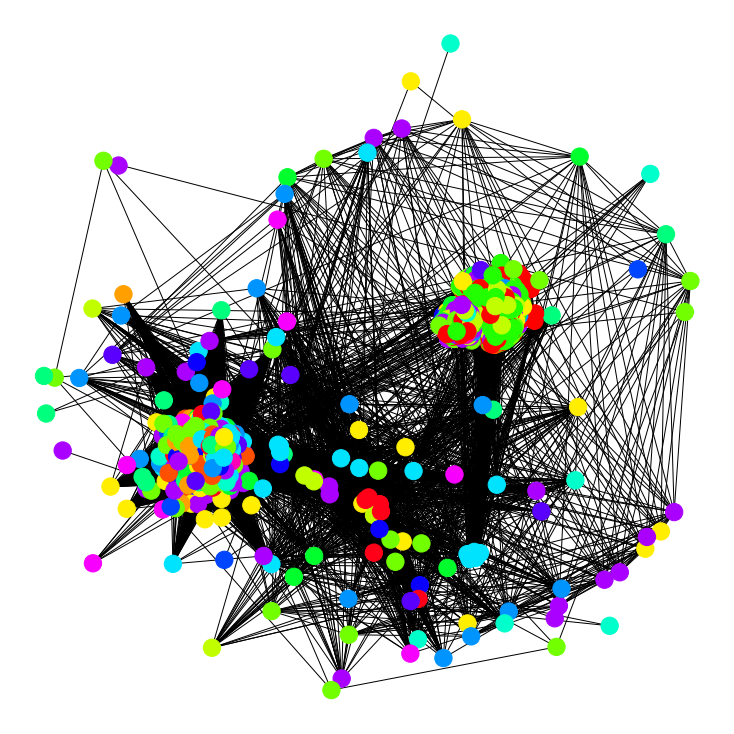

In [40]:
pos = nx.spring_layout(labeled_file_graph)

nx.draw(labeled_file_graph, pos, node_color=[HSV(class_map[x]) for x in labeled_file_graph.nodes])

In [41]:
# nx.draw(labeled_file_graph, pos, node_color=[HSV(class_map[x]) for x in labeled_file_graph.nodes])

# for x in labeled_file_graph.edges(data=True):
#     ew = x[2].get('weight')*1000
#     nx.draw_networkx_edges(labeled_file_graph, pos, edgelist=[(x[0], x[1])], width=ew)


In [42]:
train_graph = labeled_file_graph.copy()

split = 0.1
test_nodes = []
for i in labeled_file_graph.nodes():
    if random.uniform(0, 1) <= split:
        test_nodes.append(i)


train_graph.remove_nodes_from(test_nodes)

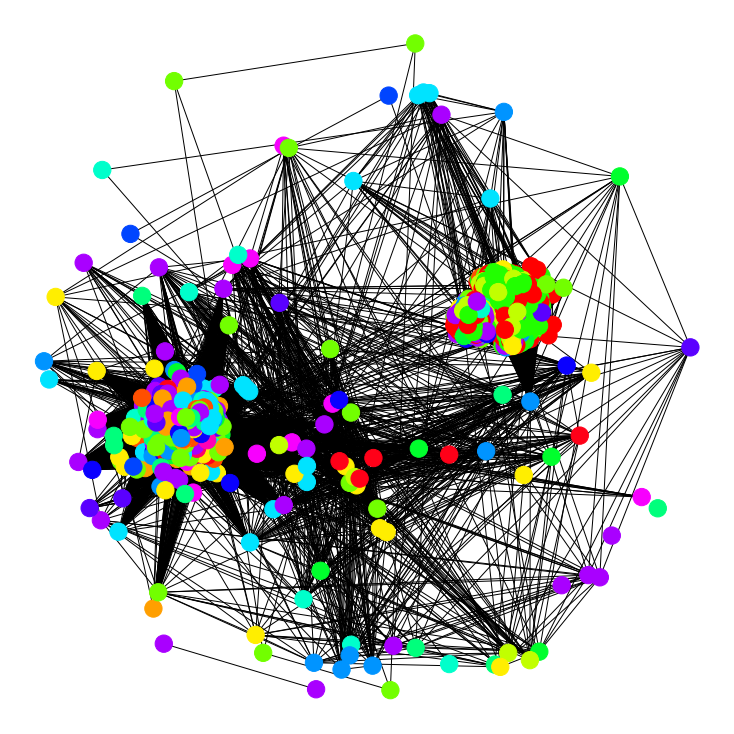

In [43]:
nx.draw(train_graph, node_color=[HSV(class_map[x]) for x in train_graph.nodes])

In [44]:
print(len(train_graph.nodes()), len(labeled_file_graph.nodes()))

1845 2052


Deepwalk Implementation

In [45]:
G_attr_matrix = nx.attr_matrix(train_graph, normalized=True)[0]
nodes_to_ids = {}
ids_to_nodes = {}

n_id = 0
for n in train_graph.nodes():
    nodes_to_ids[n] = n_id
    ids_to_nodes[n_id] = n
    n_id += 1

In [46]:
from numpy.random import choice

def choose_neighbor(G_attr_matrix, node):
    node_id = nodes_to_ids[node]
    norm = G_attr_matrix[node_id][0].tolist()[0]
    
    if sum(norm) > 0.98:

        draw = choice(range(G_attr_matrix.shape[0]), 1, p=norm)[0]
    else:
        draw = node_id
    return ids_to_nodes[draw]

In [47]:
walks_per_node = 10
walk_length = 80
walks = []
for node in train_graph:
    node_walks = 0
    while node_walks < walks_per_node:
        walk = [node]
        cur_node = node
        while len(walk) < walk_length:
            next_node = choose_neighbor(G_attr_matrix, cur_node)
            walk.append(next_node)
            cur_node = next_node
        walks.append(walk)
        node_walks += 1

In [48]:
model = Word2Vec(walks, size=16, window=4, min_count=1, sg=1, hs=0, negative=5, ns_exponent=0.75, iter=10)

In [49]:
kas_dict = {}
for scan, node in zip(mg.responses, mg.scanned_nodes):
    if 'scans' in scan:
        kaspersky = scan['scans'].get('Kaspersky')
        if kaspersky:
            result = kaspersky['result']
        else:
            result = None
        kas_dict[node] = result
    else:
        kas_dict[node] = None

In [50]:
vocab = list(model.wv.vocab)
X = model[vocab]
tsne = TSNE(n_components=2, perplexity=10, n_iter=5000)
X_transformed = tsne.fit_transform(X)
# pca = PCA(n_components=2, svd_solver='full')
# X_transformed = pca.fit_transform(X)
df = pd.DataFrame(X_transformed, index=vocab, columns=['x', 'y'])

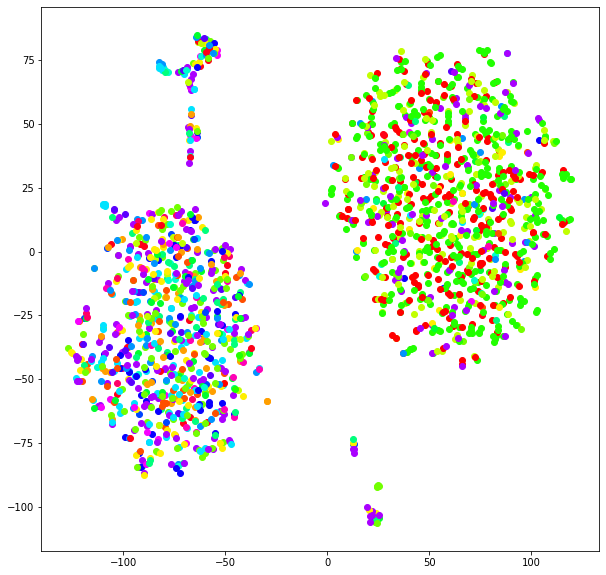

In [51]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

xs = []
ys = []
classes = []

for word, pos in df.iterrows():
    if word in class_map:    
        pt_color = HSV(class_map[word])
        ax.scatter(pos[0], pos[1], color=pt_color)

In [52]:
# Graph Induction
# Hold out some nodes
# Train CBOW model - given n neighbors predict location

# Generate a number of neighbor samples of that node and feed into model 
# loss is cosine loss between that and current embedding



In [53]:
from collections import Counter
node_label_counts = Counter([sym_dict[n] for n in labeled_file_graph.nodes])

In [54]:
# Use neighborhood average for graph induction
for node in test_nodes:
    av_vector = np.zeros(16)
    n_count = 0
    t_node_count = 0
    neighbor_labels = []
    for neighbor in labeled_file_graph.neighbors(node):
        try:
            av_vector += model.wv[neighbor]
            neighbor_labels.append(sym_dict[neighbor])
            n_count += 1
        except KeyError:
            t_node_count += 1
    av_vector /= n_count
    sims = model.wv.similar_by_vector(av_vector, topn=5)
    
    print(sym_dict[node], [sym_dict[n[0]] for n in sims])

W32.Changeup ['Trojan.Gen', 'SecurityRisk.Downldr', 'W32.Changeup', 'W32.Changeup', 'W32.Changeup!gen20']
Backdoor.Trojan ['Trojan Horse', 'WS.Reputation.1', 'Trojan.Gen', 'ML.Attribute.HighConfidence', 'Trojan.Gen']
Downloader ['Trojan.Gen', 'SecurityRisk.Downldr', 'W32.Changeup', 'W32.Changeup', 'W32.Changeup!gen20']
Downloader ['Trojan.Gen', 'SecurityRisk.Downldr', 'W32.Changeup', 'W32.Changeup', 'W32.Changeup!gen20']
Trojan.Gen ['Trojan Horse', 'ML.Attribute.HighConfidence', 'Trojan.Gen', 'WS.Reputation.1', 'Trojan.Gen']
W32.Changeup ['Trojan.Gen', 'SecurityRisk.Downldr', 'W32.Changeup', 'W32.Changeup', 'W32.Changeup!gen20']
Downloader ['Trojan.Gen', 'SecurityRisk.Downldr', 'W32.Changeup', 'W32.Changeup', 'W32.Changeup!gen20']
W32.IRCBot ['Trojan Horse', 'ML.Attribute.HighConfidence', 'Trojan.Gen', 'WS.Reputation.1', 'Trojan.Gen']
Trojan.Gen ['W32.Licum', 'Trojan.Gen.2', 'Trojan.Gen', 'ML.Attribute.HighConfidence', 'Trojan.Gen']
Downloader ['Trojan.Gen', 'SecurityRisk.Downldr', 'W3

WS.Reputation.1 ['Trojan Horse', 'WS.Reputation.1', 'ML.Attribute.HighConfidence', 'Trojan.Gen', 'Trojan.Gen']
Trojan.ADH.2 ['Trojan.Gen.2', 'Trojan.Gen.2', 'Trojan.Zeroaccess!gen8', 'W32.Kwbot.Worm', 'Adware.PigSearch']
Downloader ['SecurityRisk.Downldr', 'Trojan.Gen', 'W32.Changeup', 'W32.Changeup', 'SecShieldFraud!gen7']
W32.Changeup!gen20 ['Trojan.Gen', 'SecurityRisk.Downldr', 'W32.Changeup', 'W32.Changeup', 'W32.Changeup!gen20']
Adware.ADH ['Trojan Horse', 'WS.Reputation.1', 'Trojan.Gen', 'ML.Attribute.HighConfidence', 'Trojan.Gen']
WS.Reputation.1 ['Trojan Horse', 'ML.Attribute.HighConfidence', 'WS.Reputation.1', 'Trojan.Gen', 'Trojan.Gen']
W32.Xpaj.B ['Trojan Horse', 'WS.Reputation.1', 'ML.Attribute.HighConfidence', 'Trojan.Gen', 'Trojan.Gen']
W32.Changeup ['Trojan.Gen', 'SecurityRisk.Downldr', 'W32.Changeup', 'W32.Changeup', 'W32.Changeup!gen20']
Trojan.FakeAV!gen48 ['WS.Reputation.1', 'Trojan.Gen', 'Trojan Horse', 'Trojan.Gen', 'Trojan.Farfli!SP']
W32.Changeup ['Trojan.Gen', '

Downloader ['Trojan Horse', 'WS.Reputation.1', 'ML.Attribute.HighConfidence', 'Trojan.Gen', 'Trojan.Gen']
Backdoor.Trojan ['Trojan Horse', 'WS.Reputation.1', 'Trojan.Gen', 'ML.Attribute.HighConfidence', 'Trojan.Gen']
W32.Changeup!gen15 ['Trojan.Gen', 'SecurityRisk.Downldr', 'W32.Changeup', 'W32.Changeup', 'W32.Changeup!gen20']
W32.Changeup ['Trojan.Gen', 'SecurityRisk.Downldr', 'W32.Changeup', 'W32.Changeup', 'W32.Changeup!gen20']
W32.Griptolo ['Trojan Horse', 'WS.Reputation.1', 'ML.Attribute.HighConfidence', 'Trojan.Gen', 'Trojan.Gen']
W32.Changeup ['Trojan.Gen', 'SecurityRisk.Downldr', 'W32.Changeup', 'W32.Changeup', 'W32.Changeup!gen20']
W32.Changeup ['Trojan.Gen', 'SecurityRisk.Downldr', 'W32.Changeup', 'W32.Changeup', 'W32.Changeup!gen20']
W32.Changeup!gen11 ['Trojan.Gen', 'SecurityRisk.Downldr', 'W32.Changeup', 'W32.Changeup', 'W32.Changeup!gen20']
Trojan.Skintrim!gen3 ['Trojan Horse', 'WS.Reputation.1', 'Trojan.Gen', 'ML.Attribute.HighConfidence', 'Trojan.Gen']
Trojan Horse ['Tr

In [55]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam

In [56]:
num_neighbors = 8

In [58]:
X_train = []
y_train = []
for node in train_graph.nodes:
    neighbors = list(train_graph.neighbors(node))
    if len(neighbors) > 0:
        for i in range(400):
            neighbor_samples = []
            while len(neighbor_samples) < num_neighbors:
                neighbor_sample = choice(neighbors, 1)
                try:
                    neighbor_samples.append(model.wv[neighbor_sample]) 
                except KeyError:
                    continue
            X_train.append(neighbor_samples)
            y_train.append(nodes_to_ids[node])

In [59]:
X_test = []
final_test_nodes = []
for node in test_nodes:
    neighbors = list(labeled_file_graph.neighbors(node))
    if len(neighbors) > 0:
        neighbor_samples = []
        while len(neighbor_samples) < num_neighbors:
            neighbor_sample = choice(neighbors, 1)
            try:
                neighbor_samples.append(model.wv[neighbor_sample]) 
            except KeyError:
                continue
        X_test.append(neighbor_samples)
        final_test_nodes.append(node)
X_test = np.squeeze(np.array(X_test))

In [60]:
X_train = np.squeeze(np.array(X_train))
y_train = np.array(y_train)
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train=X_train[s,:]

n_values = np.max(y_train) + 1
y_train_oh = np.eye(n_values)[y_train]
y_train_oh = y_train_oh[s]

In [61]:
X_train.shape

(736800, 8, 16)

In [ ]:
cbow_model = Sequential()
cbow_model.add(Dense(16, activation='relu', input_shape=(num_neighbors, 16,)))
cbow_model.add(Dense(num_neighbors/4, activation='relu'))
cbow_model.add(Flatten(name='embedding'))
cbow_model.add(Dense(len(train_graph.nodes), activation='softmax'))

cbow_model.summary()

cbow_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = cbow_model.fit(X_train, y_train_oh,
                    batch_size=512,
                    epochs=30,
                    verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8, 16)             272       
_________________________________________________________________
dense_1 (Dense)              (None, 8, 2)              34        
_________________________________________________________________
embedding (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1845)              31365     
Total params: 31,671
Trainable params: 31,671
Non-trainable params: 0
_________________________________________________________________
Train on 736800 samples
Epoch 1/30
736800/736800 [==============================] - 16s 21us/sample - loss: 6.7813 - accuracy: 0.0023
Epoch 2/30
736800/736800 [==============================] - 12s 17us/sample - loss: 6.6852 - accuracy: 0.0039
Epoch 

In [ ]:
from tensorflow.keras.models import Model
intermediate_layer_model = Model(inputs=cbow_model.input,
                                 outputs=cbow_model.get_layer('embedding').output)
intermediate_output = intermediate_layer_model.predict(X_test)

In [ ]:
correct = 0
for vec, node in zip(intermediate_output, final_test_nodes):
    sims = model.wv.similar_by_vector(vec, topn=5)
    for n in sims:
        if class_map[node] == class_map[n[0]]:
            correct += 1

print(correct/(5*len(final_test_nodes)))